In [1]:
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join
import contextily

In [3]:
import os

root_path = os.getcwd()
puds = gpd.read_file(root_path+'/input/Planned_Unit_Development_(PUDs).shp', crs = {'init' :'epsg:4326'})
aff = pd.read_csv(root_path+'/input/Affordable_Housing.csv')
crosswalk = pd.read_csv(root_path+'/input/zoning_crosswalk.csv')

In [4]:
puds.info()
puds.sample()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    302 non-null    int64   
 1   PUD_NAME    302 non-null    object  
 2   PUD_WEB_UR  302 non-null    object  
 3   PUD_CHANGE  300 non-null    object  
 4   PUD_ZONING  302 non-null    object  
 5   PUD_STATUS  302 non-null    object  
 6   PUD_CASE_N  302 non-null    object  
 7   GLOBALID    302 non-null    object  
 8   WARD        301 non-null    object  
 9   SHAPEAREA   302 non-null    int64   
 10  SHAPELEN    302 non-null    int64   
 11  geometry    302 non-null    geometry
dtypes: geometry(1), int64(3), object(8)
memory usage: 28.4+ KB


,OBJECTID,PUD_NAME,PUD_WEB_UR,PUD_CHANGE,PUD_ZONING,PUD_STATUS,PUD_CASE_N,GLOBALID,WARD,SHAPEAREA,SHAPELEN,geometry
177,176229,"GG Union LP, 1250 4th St LLC & 4th st NE LLC",https://app.dcoz.dc.gov/Content/Search/ViewCas...,"Setdown 1/30/2017, DC Register 12/22/17",C-3-C,Final,14-07B,{BAEE5C0B-E774-4A0B-B1B9-A43AECC4F504},Ward 5,0,0,"POLYGON ((-76.99899 38.90958, -76.99922 38.909..."


In [5]:
aff.info()
aff.sample()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557 entries, 0 to 556
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   X                              557 non-null    float64
 1   Y                              557 non-null    float64
 2   OBJECTID                       557 non-null    int64  
 3   MAR_WARD                       557 non-null    object 
 4   ADDRESS                        554 non-null    object 
 5   PROJECT_NAME                   557 non-null    object 
 6   STATUS_PUBLIC                  557 non-null    object 
 7   AGENCY_CALCULATED              557 non-null    object 
 8   TOTAL_AFFORDABLE_UNITS         557 non-null    int64  
 9   LATITUDE                       554 non-null    float64
 10  LONGITUDE                      554 non-null    float64
 11  AFFORDABLE_UNITS_AT_0_30_AMI   557 non-null    int64  
 12  AFFORDABLE_UNITS_AT_31_50_AMI  557 non-null    int

,X,Y,OBJECTID,MAR_WARD,ADDRESS,PROJECT_NAME,STATUS_PUBLIC,AGENCY_CALCULATED,TOTAL_AFFORDABLE_UNITS,LATITUDE,...,AFFORDABLE_UNITS_AT_31_50_AMI,AFFORDABLE_UNITS_AT_51_60_AMI,AFFORDABLE_UNITS_AT_61_80_AMI,AFFORDABLE_UNITS_AT_81_AMI,CASE_ID,ADDRESS_ID,XCOORD,YCOORD,FULLADDRESS,GIS_LAST_MOD_DTTM
494,-76.967649,38.876566,1635,Ward 7,"2901 Nelson Place Southeast, Washington, Distr...",2901 Nelson Pl SE,Pipeline,DHCD,0,38.876558,...,0,0,0,0,NaN,43679.0,402807.35,134303.57,2901 NELSON PLACE SE,2021/03/22 04:01:12+00


In [6]:
crosswalk.info()
crosswalk.sample()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Zone      64 non-null     object
 1   Count     64 non-null     int64 
 2   Zone_Cat  64 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,Zone,Count,Zone_Cat
2,C-2-B,21,Commercial


In [8]:
# Create a geometry column in the affordable housing dataframe
aff['geometry'] = aff.apply(lambda row: Point(row.X, row.Y), axis=1)
aff = gpd.GeoDataFrame(aff, crs={'init' :'epsg:4326'})
aff.sample()

,X,Y,OBJECTID,MAR_WARD,ADDRESS,PROJECT_NAME,STATUS_PUBLIC,AGENCY_CALCULATED,TOTAL_AFFORDABLE_UNITS,LATITUDE,...,AFFORDABLE_UNITS_AT_51_60_AMI,AFFORDABLE_UNITS_AT_61_80_AMI,AFFORDABLE_UNITS_AT_81_AMI,CASE_ID,ADDRESS_ID,XCOORD,YCOORD,FULLADDRESS,GIS_LAST_MOD_DTTM,geometry
86,-77.001045,38.958155,1573,Ward 4,"5581 South Dakota Avenue Northeast, Washington...",Fort Totten Phase 1 (Townhome),Under Construction,DMPED,5,38.958148,...,0,2,0,NaN,288682.0,399909.66,143360.18,5581 SOUTH DAKOTA AVENUE NE,2021/03/22 04:01:12+00,POINT (-77.00104 38.95816)


In [9]:
# Use geospatial join to identify which PUDs include affordable housing projects
puds_aff = gpd.sjoin(puds, aff, op='intersects', how='left')

In [10]:
puds_aff.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 310 entries, 0 to 301
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   OBJECTID_left                  310 non-null    int64   
 1   PUD_NAME                       310 non-null    object  
 2   PUD_WEB_UR                     310 non-null    object  
 3   PUD_CHANGE                     308 non-null    object  
 4   PUD_ZONING                     310 non-null    object  
 5   PUD_STATUS                     310 non-null    object  
 6   PUD_CASE_N                     310 non-null    object  
 7   GLOBALID                       310 non-null    object  
 8   WARD                           309 non-null    object  
 9   SHAPEAREA                      310 non-null    int64   
 10  SHAPELEN                       310 non-null    int64   
 11  geometry                       310 non-null    geometry
 12  index_right                 

In [12]:
puds_info = puds_aff.merge(crosswalk[['Zone_Cat']], how='left', left_on='PUD_ZONING', right_on=crosswalk['Zone'])
puds_info.info()
puds_info.sample()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 310 entries, 0 to 309
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   OBJECTID_left                  310 non-null    int64   
 1   PUD_NAME                       310 non-null    object  
 2   PUD_WEB_UR                     310 non-null    object  
 3   PUD_CHANGE                     308 non-null    object  
 4   PUD_ZONING                     310 non-null    object  
 5   PUD_STATUS                     310 non-null    object  
 6   PUD_CASE_N                     310 non-null    object  
 7   GLOBALID                       310 non-null    object  
 8   WARD                           309 non-null    object  
 9   SHAPEAREA                      310 non-null    int64   
 10  SHAPELEN                       310 non-null    int64   
 11  geometry                       310 non-null    geometry
 12  index_right                 

,OBJECTID_left,PUD_NAME,PUD_WEB_UR,PUD_CHANGE,PUD_ZONING,PUD_STATUS,PUD_CASE_N,GLOBALID,WARD,SHAPEAREA,...,AFFORDABLE_UNITS_AT_51_60_AMI,AFFORDABLE_UNITS_AT_61_80_AMI,AFFORDABLE_UNITS_AT_81_AMI,CASE_ID,ADDRESS_ID,XCOORD,YCOORD,FULLADDRESS,GIS_LAST_MOD_DTTM,Zone_Cat
73,176048,Ashmeade Associates,https://app.dcoz.dc.gov/Content/Search/ViewCas...,"Official Digital Zoning Map of July 1, 2010",None,Final,83-11,{760FEF6F-8433-465D-9F4E-8175EF9B8791},Ward 1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other/Mixed Use


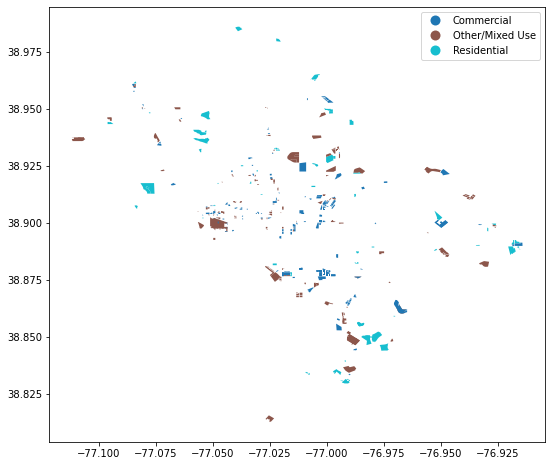

In [13]:
# Create a map of PUDs by Zoning Category
# remove the NaN
puds_info = puds_info[~puds_info['Zone_Cat'].isnull()]
puds_info.plot(column='Zone_Cat', legend=True, figsize=(16,8));

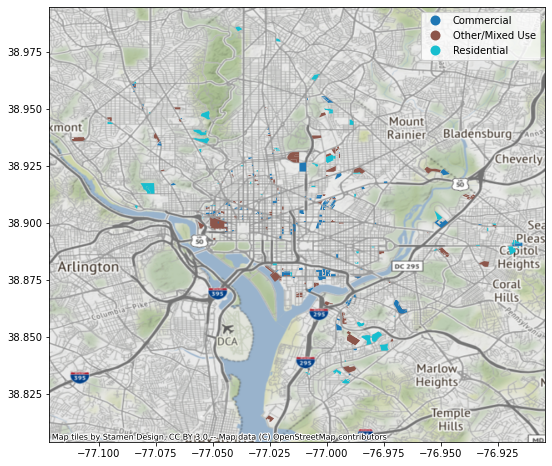

In [15]:
puds_info = puds_info[~puds_info['Zone_Cat'].isnull()]
ax = puds_info.plot(column='Zone_Cat', legend=True, figsize=(16,8))
contextily.add_basemap(ax,crs={'init' :'epsg:4326'})

/Users/michaelzhao/opt/anaconda3/envs/geo/lib/python3.8/site-packages/geopandas/plotting.py:470: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


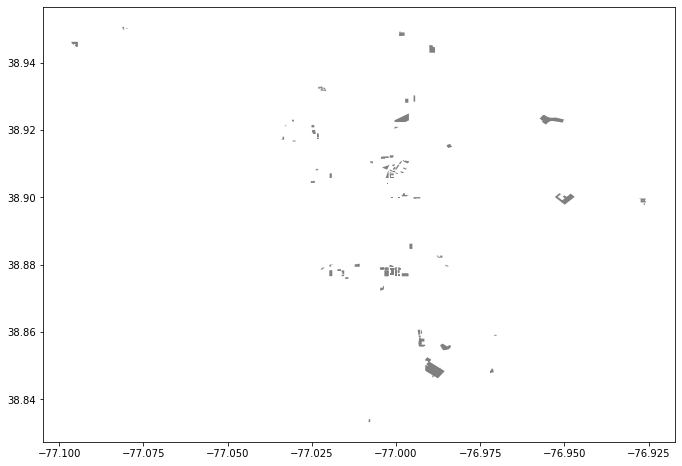

In [79]:
# Create a map of just the PUDs that provide Affordable Housing
puds_info[puds_info['TOTAL_AFFORDABLE_UNITS']>0].plot(column='TOTAL_AFFORDABLE_UNITS',color='grey', figsize=(16,8));

In [84]:
%matplotlib inline

import geopandas
import rasterio


ImportError: dlopen(/Users/michaelzhao/opt/anaconda3/envs/geo/lib/python3.8/site-packages/rasterio/_base.cpython-38-darwin.so, 2): Library not loaded: @rpath/libgeos_c.1.dylib
  Referenced from: /Users/michaelzhao/opt/anaconda3/envs/geo/lib/libgdal.27.dylib
  Reason: Incompatible library version: libgdal.27.dylib requires version 16.0.0 or later, but libgeos_c.dylib provides version 13.0.0